In [80]:
# Libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import matplotlib.animation as animation
from tqdm import tqdm

# Extend PATH Variable
import sys
sys.path.append("src/")

# NanoNets Simulation Tool
import nanonets

# Plot Colors
blue_color  = '#348ABD'
red_color   = '#A60628'

In [81]:
# Network Style
network_topology = "cubic"

# Network Parameter
# topology_parameter  = {
#     "Np"    : 25,
#     "Nj"    : 4,
#     "e_pos" : [[-1,-1],[1,1]]
# }
topology_parameter  = {
    "Nx"    : 7,
    "Ny"    : 7,
    "Nz"    : 1,
    "e_pos" : [[0,0,0],[3,0,0],[0,3,0],[6,0,0],[0,6,0],[6,3,0],[3,6,0],[6,6,0]]
}

# Save Folder
folder  = "test_runs/"

# Topology Class
np_network_sim = nanonets.simulation(network_topology=network_topology, folder=folder, topology_parameter=topology_parameter)

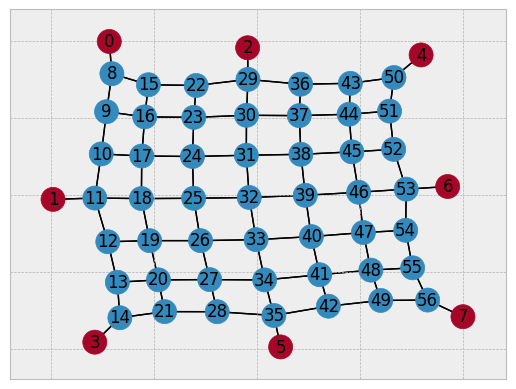

In [82]:
# Return Graph Object
G   = np_network_sim.return_graph_object()

# Node Colors
colors                                  = np.repeat('#348ABD', np_network_sim.N_particles+np_network_sim.N_electrodes)
colors[:np_network_sim.N_electrodes]    = '#A60628'

# Display Graph
with plt.style.context(["bmh"]):

    fig = plt.figure()
    ax  = fig.add_subplot()
    nx.draw_networkx(G=G,  ax=ax, node_color=colors, arrows=False)
    plt.show()

#### Input Voltage

Number of Steps: 50000


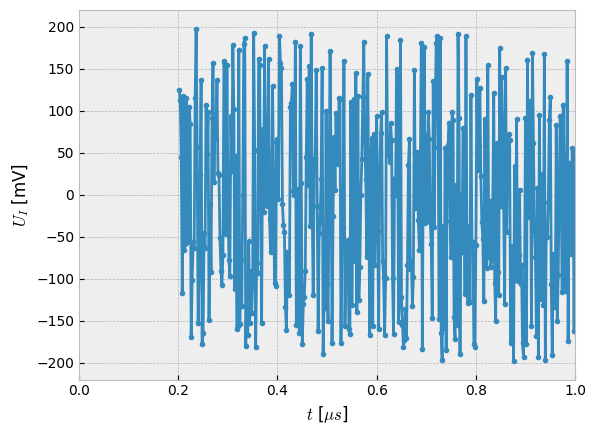

In [47]:
# Define Time Scale
start_val   = 100
step_size   = 2e-9
max_time    = 1e-4
time_steps  = np.arange(0,max_time,step_size)
N_steps     = len(time_steps)
time        = time_steps[start_val+1:]*10**6

print(f"Number of Steps: {N_steps}")

input_volt = np.random.uniform(-0.2,0.2,N_steps)
inputs     = 1000*input_volt[start_val+1:]

# Voltage Array
N_electrodes    = np_network_sim.N_electrodes
voltages        = np.zeros((N_steps, N_electrodes+1))
voltages        = np.zeros((N_steps, N_electrodes+1))
voltages[:,0]   = input_volt

# Plot
with plt.style.context("bmh"):
    
    plt.plot(time, inputs, '.-')
    plt.xlabel("$t$ [$\mu s$]")
    plt.ylabel("$U_I$ [mV]")
    plt.xlim(0,1)
    plt.show()

In [92]:
pred_d  = 1
offset  = 0
train_S = 5000
u_train = voltages[offset:(train_S+offset)]
u_test  = voltages[(train_S+offset):]
y_train = voltages[(offset-pred_d):(train_S+offset-pred_d)]
y_test  = voltages[(train_S+offset-pred_d):-pred_d]

t_train = time_steps[offset:(train_S+offset)]
t_test  = time_steps[(train_S+offset-pred_d):-pred_d]

In [57]:
def run_simulation(voltages, time_steps, target_electrode, network_topology, topology_parameter, R, Rstd, store_per_it_min=0, store_per_it_max=0, folder="", n_stat=20, save_th=.1, start_val=100):

    output_vals     = []
    microstate      = []
    landscape       = []
    net_currents    = []
    network_classes = []
    
    for _ in tqdm(range(n_stat)):
    
        np_network_sim = nanonets.simulation(network_topology=network_topology, folder=folder, topology_parameter=topology_parameter)
        np_network_sim.run_var_voltages(voltages=voltages, time_steps=time_steps, target_electrode=target_electrode, save_th=save_th,
                                        store_per_it_min=store_per_it_min, store_per_it_max=store_per_it_max, R=R, Rstd=Rstd)
        
        # Return Output Current
        output_df               = pd.DataFrame(np_network_sim.return_output_values()).iloc[start_val:,1:3].reset_index(drop=True)
        output_df.columns       = ["Jumps","Current"]
        output_df["Current"]    = output_df["Current"]/1000

        # Return Microstate
        microstate_df   = pd.DataFrame(np_network_sim.return_microstates()).iloc[start_val:,:].reset_index(drop=True)

        # Return Landscape
        landscape_df    = pd.DataFrame(np_network_sim.return_potential_landscape()).iloc[start_val:,np_network_sim.N_electrodes:].reset_index(drop=True)

        # Return Network Currents
        jump_paths, network_I   = np_network_sim.return_network_currents()
        network_I_df            = pd.DataFrame(network_I)
        network_I_df.columns    = jump_paths
        network_I_df            = network_I_df.iloc[start_val:].reset_index(drop=True)

        # Append Results
        output_vals.append(output_df)
        microstate.append(microstate_df)
        landscape.append(landscape_df)
        net_currents.append(network_I_df)
        network_classes.append(np_network_sim)

    outputs = {
        "output"            : output_vals,
        "microstate"        : microstate,
        "landscape"         : landscape,
        "net_currents"      : net_currents,
        "network_classes"   : network_classes
    }

    return outputs

In [64]:
n_stat              = 20
simulation_outputs  = run_simulation(voltages=u_train, time_steps=t_train, target_electrode=N_electrodes-1,
                    network_topology=network_topology, topology_parameter=topology_parameter,
                    R=25.0, Rstd=0.0, start_val=start_val, n_stat=n_stat)

100%|██████████| 20/20 [00:25<00:00,  1.28s/it]


In [84]:
dfs = []

for _ in range(n_stat):
    df_tmp      = pd.DataFrame()
    df_tmp['t'] = t_train[start_val+1:]
    df_tmp['U'] = u_train[start_val+1:,0]
    df_currs    = simulation_outputs['net_currents'][0]
    cols        = df_currs.columns

    for i in range(N_electrodes):

        for col in cols:
            if col[0] == i:
                a = df_currs[col]
            if col[1] == i:
                b = df_currs[col]
        
        diff            = b - a
        df_tmp[f'I{i}'] = diff
    dfs.append(df_tmp)

in_out          = pd.DataFrame(np.mean(dfs,axis=0))
in_out_error    = pd.DataFrame(np.std(dfs,axis=0))/np.sqrt(n_stat)

in_out.columns          = df_tmp.columns
in_out_error.columns    = df_tmp.columns

In [85]:
in_out

,t,U,I0,I1,I2,I3,I4,I5,I6,I7
0,2.020000e-07,0.124839,-9812.294679,0.000000,516.436562,0.0,0.000000,0.0,0.0,0.0
1,2.040000e-07,0.112280,-8024.651413,1504.622140,1003.081427,0.0,0.000000,0.0,0.0,0.0
2,2.060000e-07,0.045518,-6014.295033,3007.147516,1503.573758,0.0,0.000000,0.0,0.0,0.0
3,2.080000e-07,-0.116873,0.000000,1004.196054,1004.196054,0.0,0.000000,0.0,0.0,0.0
4,2.100000e-07,0.117213,8578.969135,1009.290486,0.000000,0.0,504.645243,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4894,9.990000e-06,-0.075967,10425.429748,521.271487,0.000000,0.0,0.000000,0.0,0.0,0.0
4895,9.992000e-06,-0.110631,2254.992962,-1691.244722,-1691.244722,0.0,0.000000,0.0,0.0,0.0
4896,9.994000e-06,0.182806,5605.254295,-1019.137145,-1019.137145,0.0,0.000000,0.0,0.0,0.0
4897,9.996000e-06,-0.041804,-19657.878364,1512.144490,504.048163,0.0,0.000000,0.0,0.0,0.0


In [86]:
in_out_error

,t,U,I0,I1,I2,I3,I4,I5,I6,I7
0,5.918823e-24,6.206335e-18,4.067384e-13,0.000000e+00,2.542115e-14,0.0,0.0,0.0,0.0,0.0
1,5.918823e-24,0.000000e+00,6.101076e-13,1.016846e-13,7.626345e-14,0.0,0.0,0.0,0.0,0.0
2,1.775647e-23,3.103168e-18,6.101076e-13,3.050538e-13,1.525269e-13,0.0,0.0,0.0,0.0,0.0
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
4,1.183765e-23,3.103168e-18,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4894,3.788046e-22,3.103168e-18,8.134768e-13,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
4895,3.788046e-22,3.103168e-18,0.000000e+00,1.525269e-13,1.525269e-13,0.0,0.0,0.0,0.0,0.0
4896,7.576093e-22,6.206335e-18,2.033692e-13,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0
4897,3.788046e-22,3.103168e-18,8.134768e-13,5.084230e-14,1.271057e-14,0.0,0.0,0.0,0.0,0.0


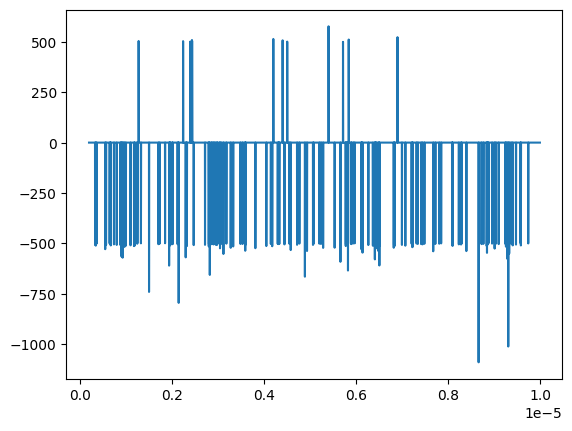

In [87]:
col = 'I7'

fig = plt.figure()
ax  = fig.add_subplot()
ax.errorbar(in_out['t'], in_out[col], in_out_error[col])
plt.show()

In [89]:
X = in_out.loc[:,'I1':].values
y = y_train.copy()
X

array([[    0.        ,   516.43656208,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [ 1504.62214001,  1003.08142667,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [ 3007.14751635,  1503.57375817,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [-1019.13714461, -1019.13714461,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [ 1512.14448953,   504.04816318,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [  644.24536306,   644.24536306,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

In [91]:
y_train

array([], shape=(0, 9), dtype=float64)

In [46]:
regularization_coeff    = 1e-8
W_out                   = np.linalg.solve(np.dot(X,X.T) + regularization_coeff*np.eye(X.shape[0]), np.dot(X,y.T)).T

ValueError: shapes (4899,7) and (4899,) not aligned: 7 (dim 1) != 4899 (dim 0)